## Import modules/scripts and optimize portfolio weights:

In [1]:
from datetime import date, datetime, timedelta
from cov_matrix import MPTCovMat, WeightOptimizer
from JSONReader import read_json
import pandas as pd
import yfinance as yf
import torch

ticker_list = read_json('omxs30.json')
tickers = yf.Tickers(ticker_list)
start = date(2021,1,1)
end = date(2021,10,6)
rr = 0.027
rr_period = timedelta(120)

#get data
data = MPTCovMat(tickers=tickers,start=start,end=end)
returns = data.log_return_df
col_indices = data.col_indices
asset_names = [col_indices[i] for i in sorted(col_indices.keys())]
num_iter = 10000
allocator = WeightOptimizer(lr=1e-3,cov_matrix=torch.tensor(data.cov_matrix.values),returns=torch.tensor(returns.values),risk_free=rr,risk_free_period=rr_period,num_iter=num_iter)
sharpes, pf_returns, pf_stds = allocator.optimize_weights()
weights = pd.DataFrame(allocator.alloc_weights.numpy(force=True), index=asset_names, columns=['Weights'])
weights.index.name = 'Ticker'
weights['Weights %'] = weights['Weights']*100
weights['Weights %'].to_csv('weights.csv')
print(weights['Weights %'])

[*********************100%***********************]  30 of 30 completed
/Users/daniel/Desktop/Sidoprojekt/IRB_ML/PortOpt/CovMat/cov_matrix.py:42: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  portfolio_var = torch.matmul(weights.T,torch.matmul(cov_matrix,weights))


Ticker
ABB.ST          0.020222
ALFA.ST         0.127347
ASSA-B.ST       0.017963
ATCO-A.ST       0.021401
ATCO-B.ST       0.023581
AZN.ST         15.366319
BOL.ST          0.030180
ELUX-B.ST       0.027586
ERIC-B.ST       0.035719
ESSITY-B.ST     0.022567
EVO.ST          0.032318
GETI-B.ST      24.700268
HEXA-B.ST       0.021302
HM-B.ST         0.026011
INVE-B.ST       0.017525
KINV-B.ST       0.021919
NDA-SE.ST      36.109970
NIBE-B.ST       0.150746
SAAB-B.ST       0.026697
SAND.ST         0.030721
SBB-B.ST       22.533731
SCA-B.ST        0.028739
SEB-A.ST        0.335508
SHB-A.ST        0.028403
SINCH.ST        0.023199
SKF-B.ST        0.032005
SWED-A.ST       0.036900
TEL2-B.ST       0.099061
TELIA.ST        0.021856
VOLV-B.ST       0.030246
Name: Weights %, dtype: float32


### Plot sharpe ratios to number of iterations

Text(0, 0.5, 'Sharpe Ratio')

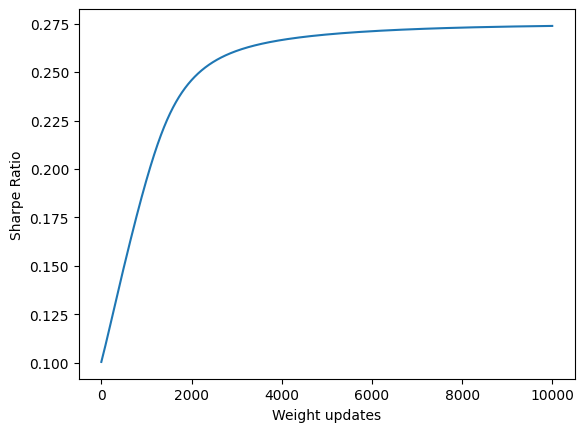

In [2]:
import matplotlib.pyplot as plt
x_df = pd.DataFrame(range(0,num_iter))
plt.plot(x_df,sharpes.numpy(force=True),)
plt.xlabel('Weight updates')
plt.ylabel('Sharpe Ratio')

## Backtesting

In [3]:
from backtesting import BackTester
comp_weights = pd.DataFrame({'Weights':[1/30]*30},index=asset_names) #equal weighting
test_start=date(2021,10,7)
test_end=date(2022,1,1 )
tester = BackTester(comp_weights=comp_weights,test_weights=pd.DataFrame(weights['Weights']),start=test_start,end=test_end,tickers=tickers)

[*********************100%***********************]  30 of 30 completed

TESTER


#### Plot backtest results

Weights    0.087103
Name: 2021-12-30 00:00:00+00:00, dtype: float64
0.12047430997592001


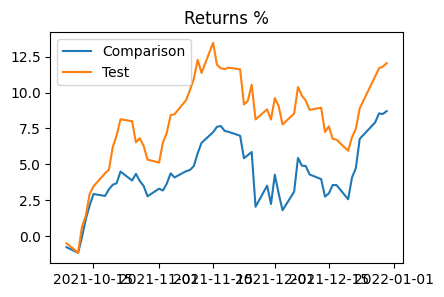

In [4]:
import matplotlib.dates as mdates
comp_returns = tester.cumulative_returns(tester.comparison_portfolio_returns)
test_returns = tester.cumulative_returns(tester.test_portfolio_returns)
ax1=plt.subplot(1,2,1)
ax1.set_title('Returns %')
ax1.figure.set_size_inches(10,3)
ax1.xaxis.set_major_formatter(mdates.AutoDateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.plot(comp_returns.mul(100))
ax1.plot(test_returns.mul(100))
ax1.legend(['Comparison','Test'])
print(comp_returns.iloc[-1,:])
print(max(test_returns.iloc[-1,:]))